## frathom
## Homework 4 Part 3

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import helper
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset
import glob
import librosa
import math
from torch import optim as optim
import torchvision

In [ ]:
mnist_train=torchvision.datasets.MNIST('mnist',train=True,download=True,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,), (0.5,))]))

In [ ]:
trainc=torch.utils.data.DataLoader(mnist_train,batch_size=50,shuffle=True)

In [ ]:
onehot = torch.FloatTensor(np.eye(10)).cuda()
onehot[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [ ]:
class generator_m(nn.Module):
  def __init__(self,input_units,out):
    self.input_units=input_units
    super(generator_m,self).__init__()
    self.inp=nn.Sequential(nn.Linear(input_units,512),nn.LeakyReLU(0.2))
    self.l1=nn.Sequential(nn.Linear(512,1024),nn.LeakyReLU(0.2))
    self.l2=nn.Sequential(nn.Linear(1024,2048),nn.LeakyReLU(0.2))
    #self.l3=nn.Sequential(nn.Linear(2048,4096),nn.ReLU(),nn.Dropout(0.2))
    self.l4=nn.Sequential(nn.Linear(2048,out),nn.Tanh())
  
  def forward(self,x,label):
    #x=x.view(-1,self.input_units)
    self.x=x
    self.label=label
    o=onehot[self.label]
    x=torch.cat([x,o],1)
    self.x1=self.inp(x)
    self.x2=self.l1(self.x1)
    self.x3=self.l2(self.x2)
    #self.x4=self.l3(self.x3)
    self.out=self.l4(self.x3)
    return self.out

In [ ]:
class discriminator_m(nn.Module):
  def __init__(self,input_units,out):
    self.input_units=input_units
    super(discriminator_m,self).__init__()
    self.inp=nn.Sequential(nn.Linear(input_units,2048),nn.LeakyReLU(0.2),nn.Dropout(0.3))
    self.l1=nn.Sequential(nn.Linear(2048,1024),nn.LeakyReLU(0.2),nn.Dropout(0.3))
    self.l2=nn.Sequential(nn.Linear(1024,512),nn.LeakyReLU(0.2),nn.Dropout(0.3))
    #self.l3=nn.Sequential(nn.Linear(512,256),nn.ReLU(),nn.Dropout(0.3))
    self.l4=nn.Sequential(nn.Linear(512,out),nn.Sigmoid())
  
  def forward(self,x,label):
    #x=x.view(-1,self.input_units)
    self.x=x
    self.label=label
    o=onehot[self.label]
    x=torch.cat([x,o],1)
    self.x1=self.inp(x)
    self.x2=self.l1(self.x1)
    self.x3=self.l2(self.x2)
    #self.x4=self.l3(self.x3)
    self.out=self.l4(self.x3)
    return self.out

In [ ]:
gen=generator_m(110,784).cuda()

In [ ]:
dis=discriminator_m(794,1).cuda()

In [ ]:
dis_optim = optim.Adam(dis.parameters(), lr=0.00003)
gen_optim = optim.Adam(gen.parameters(), lr=0.00003)

loss = nn.BCELoss()

In [ ]:

no_of_epochs=300


real_acc_list=[]
fake_acc_list=[]

for i in range(no_of_epochs):
  length1=0
  length2=0
  acc_fake=0
  acc_real=0
  for num,dat in enumerate(trainc):
    dis.train()
    noise_input=torch.randn(50,100).cuda()
    noise_labels=torch.randint(0,10,(50,)).cuda()
    gen_output=gen.forward(noise_input,noise_labels)
    im,la=dat
    dis_input=im.view(50,784).cuda()
    dis_labels=la.cuda()
    t_labels=torch.ones(50).cuda()
    dis_optim.zero_grad()
    dis_output_t=dis.forward(dis_input,dis_labels).view(50)
    acc_re=torch.round(dis_output_t)
    length2+=dis_labels.size(0)
    acc_real+=(torch.sum(acc_re).item())
    dis_loss_t=loss(dis_output_t,t_labels)
    dis_output_g=dis.forward(gen_output,noise_labels).view(50)
    acc_fa=torch.round(dis_output_g)
    acc_fake+=(torch.sum(acc_fa).item())
    length1+=noise_labels.size(0)
    dis_loss_g=loss(dis_output_g,torch.zeros(50).cuda())
    dis_total_loss=(dis_loss_t+dis_loss_g)/2


    dis_total_loss.backward()
    dis_optim.step()
    

    gen.train()
    gen_optim.zero_grad()
    gen_output=gen.forward(noise_input,noise_labels)
    dis_output_g=dis.forward(gen_output,noise_labels).view(50)
    gen_loss=loss(dis_output_g,t_labels)
    gen_loss.backward()
    gen_optim.step()

  real_acc_list.append(acc_real/length2)
  fake_acc_list.append(acc_fake/length1)  




  print("epoch {} done and the discriminator loss and generator loss are {},  {} respectively ".format(i,dis_total_loss,gen_loss))

epoch 0 done and the discriminator loss and generator loss are 0.25776350498199463,  2.1049160957336426 respectively 
epoch 1 done and the discriminator loss and generator loss are 0.060611989349126816,  4.4473958015441895 respectively 
epoch 2 done and the discriminator loss and generator loss are 0.1695312112569809,  3.9408257007598877 respectively 
epoch 3 done and the discriminator loss and generator loss are 0.0182613767683506,  7.007094383239746 respectively 
epoch 4 done and the discriminator loss and generator loss are 0.027448052540421486,  6.830223083496094 respectively 
epoch 5 done and the discriminator loss and generator loss are 0.027809105813503265,  9.233158111572266 respectively 
epoch 6 done and the discriminator loss and generator loss are 0.04706846550107002,  7.945505619049072 respectively 
epoch 7 done and the discriminator loss and generator loss are 0.02197444625198841,  5.217778205871582 respectively 
epoch 8 done and the discriminator loss and generator loss a

In [ ]:

with torch.no_grad():
  noise = torch.randn(100,100).cuda()
  noise_labels = torch.LongTensor([i for i in range(10) for j in range(10)]).cuda()
  generated_data = gen(noise, noise_labels).cpu().view(100, 28, 28)

Generated Images


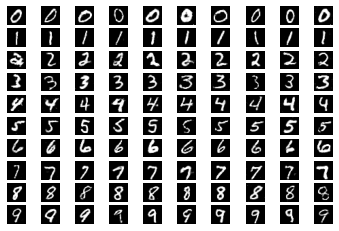

In [ ]:
print("Generated Images")
ind=0
f,a=plt.subplots(10,10)
for i in range(10):
 for j in range(10):
    a[i][j].imshow(generated_data[ind,:,:],cmap='gray')
    a[i][j].axis('off')
    ind+=1


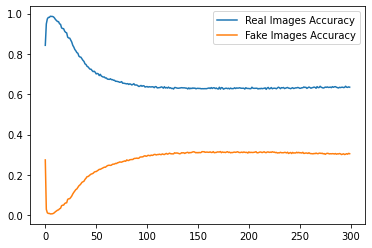

In [ ]:
plt.plot(range(300),real_acc_list)
plt.plot(range(300),fake_acc_list)
plt.legend(['Real Images Accuracy','Fake Images Accuracy'])
plt.show()